In [1]:
with open("tcpdump.txt", "r") as f:
    for i, line in enumerate(f):
        print(f"[{i+1}] {line.strip()}")
        if i == 4: break  # only first 5 lines


[1] 1   0.000000 20.52.64.201 â†’ 192.168.1.8  TCP 54 443 â†’ 53183 [RST, ACK] Seq=1 Ack=1 Win=0 Len=0
[2] 2   2.880997  192.168.1.8 â†’ 20.42.73.31  TCP 54 53202 â†’ 443 [FIN, ACK] Seq=1 Ack=1 Win=253 Len=0
[3] 3   2.881239 2401:4900:8840:b020:556f:99ec:de73:e6dd â†’ 2600:1417:56::174c:9d09 TCP 74 53200 â†’ 443 [FIN, ACK] Seq=1 Ack=1 Win=252 Len=0
[4] 4   2.881485  192.168.1.8 â†’ 204.79.197.222 TCP 54 53208 â†’ 443 [FIN, ACK] Seq=1 Ack=1 Win=252 Len=0
[5] 5   2.881591  192.168.1.8 â†’ 13.107.18.254 TCP 54 53205 â†’ 443 [FIN, ACK] Seq=1 Ack=1 Win=255 Len=0


In [3]:
#Token-Based Parsing

In [9]:
import pandas as pd
import re

def parse_tcpdump_file(file_path):
    rows = []
    
    with open(file_path, 'r', encoding="utf-8", errors="replace") as f:
        for line in f:
            # Fix arrow symbol
            line = line.replace("â†’", "→").strip()

            # Match TCP or UDP packets (IPv4 or IPv6)
            match = re.match(
                r"^\s*\d+\s+([\d\.]+)\s+"         # Time
                r"(\S+)\s+→\s+(\S+)\s+"           # Src → Dst
                r"(TCP|UDP)\s+\d+\s+"             # Protocol + length
                r"(\d+)\s+→\s+(\d+)\s*"            # Src port → Dst port
                r"(?:\[([^\]]*)\])?",              # Optional [FLAGS]
                line
            )

            if match:
                time, src, dst, proto, src_port, dst_port, flags = match.groups()
                flags = flags or ""

                # Extract optional Seq, Ack, Win, Len
                seq_match = re.search(r"Seq=(\d+)", line)
                ack_match = re.search(r"Ack=(\d+)", line)
                win_match = re.search(r"Win=(\d+)", line)
                len_match = re.search(r"Len=(\d+)", line)

                rows.append({
                    "time": float(time),
                    "src": src,
                    "dst": dst,
                    "protocol": proto,
                    "src_port": int(src_port),
                    "dst_port": int(dst_port),
                    "flags": flags,
                    "seq": int(seq_match.group(1)) if seq_match else None,
                    "ack": int(ack_match.group(1)) if ack_match else None,
                    "win": int(win_match.group(1)) if win_match else None,
                    "length": int(len_match.group(1)) if len_match else None
                })
    
    return pd.DataFrame(rows)


In [11]:
df = parse_tcpdump_file("tcpdump.txt")
print(df.head())
print(df.columns)
print(f"Parsed {len(df)} rows")


       time                                      src                      dst  \
0  0.000000                             20.52.64.201              192.168.1.8   
1  2.880997                              192.168.1.8              20.42.73.31   
2  2.881239  2401:4900:8840:b020:556f:99ec:de73:e6dd  2600:1417:56::174c:9d09   
3  2.881485                              192.168.1.8           204.79.197.222   
4  2.881591                              192.168.1.8            13.107.18.254   

  protocol  src_port  dst_port     flags  seq  ack  win  length  
0      TCP       443     53183  RST, ACK    1  1.0    0       0  
1      TCP     53202       443  FIN, ACK    1  1.0  253       0  
2      TCP     53200       443  FIN, ACK    1  1.0  252       0  
3      TCP     53208       443  FIN, ACK    1  1.0  252       0  
4      TCP     53205       443  FIN, ACK    1  1.0  255       0  
Index(['time', 'src', 'dst', 'protocol', 'src_port', 'dst_port', 'flags',
       'seq', 'ack', 'win', 'length'],
    

In [13]:
#Encode TCP Flags

In [15]:
from sklearn.preprocessing import LabelEncoder

df['flag_encoded'] = LabelEncoder().fit_transform(df['flags'])


In [16]:
#Convert Time into Bins (Time Buckets) 
# divide into 10 equal time bins

In [17]:
df['time_bin'] = pd.cut(df['time'], bins=10)  


In [18]:
df['time_rounded'] = df['time'].astype(float).round(0)


In [23]:
#Visualize TCP Flag Frequency Over Time

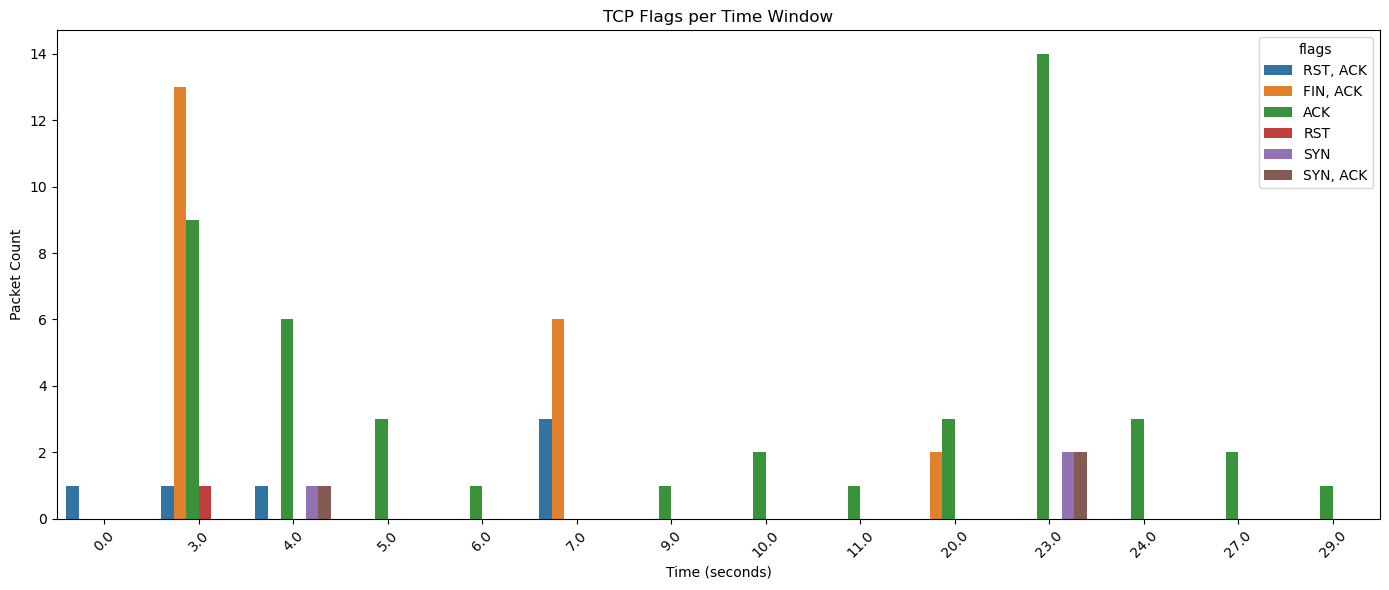

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
sns.countplot(data=df, x='time_rounded', hue='flags')
plt.xticks(rotation=45)
plt.title("TCP Flags per Time Window")
plt.ylabel("Packet Count")
plt.xlabel("Time (seconds)")
plt.tight_layout()
plt.show()


In [26]:
#Train ML Model

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X = df[['time']] 
y = df['flag_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
print("Accuracy:", clf.score(X_test, y_test))


Accuracy: 0.75


In [31]:
#One-Hot Encode TCP Flags

In [33]:
flags_dummies = df['flags'].str.get_dummies(sep=', ')
df = pd.concat([df, flags_dummies], axis=1)


In [35]:
#Categorize Port Numbers

In [37]:
def categorize_port(port):
    try:
        port = int(port)
        if port in [80, 443, 21, 22, 23, 25]:
            return 'well_known'
        elif port < 1024:
            return 'system'
        elif port < 49152:
            return 'user'
        else:
            return 'dynamic'
    except:
        return 'unknown'

df['src_port_cat'] = df['src_port'].apply(categorize_port)
df['dst_port_cat'] = df['dst_port'].apply(categorize_port)


In [39]:
df = pd.get_dummies(df, columns=['src_port_cat', 'dst_port_cat'])


In [41]:
#Direction: Internal → External or External → Internal

In [43]:
def classify_direction(src, dst):
    if '192.168.1.8' in src:
        return 'outbound'
    elif '192.168.1.8' in dst:
        return 'inbound'
    else:
        return 'external'

df['direction'] = df.apply(lambda row: classify_direction(row['src'], row['dst']), axis=1)
df = pd.get_dummies(df, columns=['direction'])


In [45]:
#Time of Day Feature

In [47]:
def time_of_day(seconds):
    hour = int(seconds) % 86400 // 3600
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['timeofday'] = df['time'].apply(time_of_day)
df = pd.get_dummies(df, columns=['timeofday'])


In [49]:
print(df.columns)
print(df.head())


Index(['time', 'src', 'dst', 'protocol', 'src_port', 'dst_port', 'flags',
       'seq', 'ack', 'win', 'length', 'flag_encoded', 'time_bin',
       'time_rounded', 'ACK', 'FIN', 'RST', 'SYN', 'src_port_cat_dynamic',
       'src_port_cat_well_known', 'dst_port_cat_dynamic', 'dst_port_cat_user',
       'dst_port_cat_well_known', 'direction_external', 'direction_inbound',
       'direction_outbound', 'timeofday_night'],
      dtype='object')
       time                                      src                      dst  \
0  0.000000                             20.52.64.201              192.168.1.8   
1  2.880997                              192.168.1.8              20.42.73.31   
2  2.881239  2401:4900:8840:b020:556f:99ec:de73:e6dd  2600:1417:56::174c:9d09   
3  2.881485                              192.168.1.8           204.79.197.222   
4  2.881591                              192.168.1.8            13.107.18.254   

  protocol  src_port  dst_port     flags  seq  ack  win  ...  SYN  \
0 

In [51]:
#Flag Trend Visualization over Time

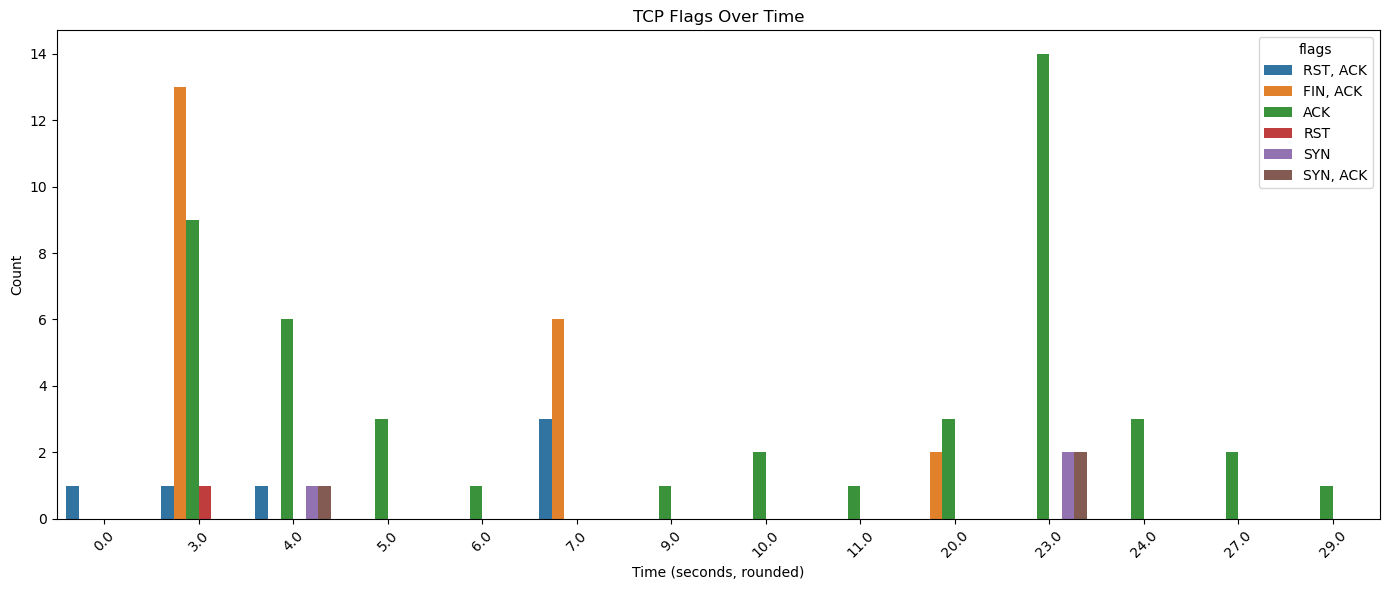

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.countplot(data=df, x='time_rounded', hue='flags')
plt.title("TCP Flags Over Time")
plt.xlabel("Time (seconds, rounded)")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [55]:
#Train a Classifier to Predict TCP Flag Type

In [57]:
print(df.columns.tolist())


['time', 'src', 'dst', 'protocol', 'src_port', 'dst_port', 'flags', 'seq', 'ack', 'win', 'length', 'flag_encoded', 'time_bin', 'time_rounded', 'ACK', 'FIN', 'RST', 'SYN', 'src_port_cat_dynamic', 'src_port_cat_well_known', 'dst_port_cat_dynamic', 'dst_port_cat_user', 'dst_port_cat_well_known', 'direction_external', 'direction_inbound', 'direction_outbound', 'timeofday_night']


In [59]:
requested_features = [
    'time', 'ACK', 'FIN', 'PSH', 'RST', 'SYN',
    'src_port_cat_unknown', 'src_port_cat_dynamic', 'dst_port_cat_unknown',
    'dst_port_cat_well_known', 'direction_external', 'direction_inbound',
    'direction_outbound', 'timeofday_night'
]

# Keep only columns that exist
features = [col for col in requested_features if col in df.columns]

X = df[features]
y = df['flag_encoded']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Accuracy:", model.score(X_test, y_test))


Accuracy: 1.0
